<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [ ]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

Cloning into 'AE-w.-Bottleneck-Residual-Blocks'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 163 (delta 79), reused 76 (delta 25), pack-reused 0
Receiving objects: 100% (163/163), 3.66 MiB | 10.45 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/AE-w.-Bottleneck-Residual-Blocks


In [ ]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

# **Loading the dataset**

In [ ]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteWJBSYM/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteWJBSYM/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# **Defining the model**

In [ ]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [ ]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)
###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(64, 1, 3, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(32, 1, 3, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_26 (ReLU)             (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_27 (ReLU)             (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_28 (ReLU)             (None, 1024)              0   

In [ ]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         17337091  
                                                                 
Total params: 31184195 (118.96 MB)
Trainable params: 31163075 (118.88 MB)
Non-trainable params: 21120 (82.50 KB)
_________________________________________________________________


# **Continuous Bernoulli log loss**

We intend to use this as one of the metrics.

In [ ]:
l_cutoff = 0.495
u_cutoff = 0.505

def norm_CB(z):

    gate = math.logical_and(math.greater(z,l_cutoff), math.greater(u_cutoff,z))

    z_reg = tf.where(gate, l_cutoff, z)

    norm_reg = (2*math.atanh(1 - 2*z_reg))/(1 - 2*z_reg)
    norm_taylor = 2.0 + (8.0/3.0)*math.pow(z-0.5,2) + (32.0/5.0)*math.pow(z-0.5,4)  +  (128.0/7.0)*math.pow(z-0.5,6)


    norm = tf.where(gate, norm_taylor, norm_reg)

    return norm

def CB_logloss(true, pred):
  true = layers.Flatten()(true)
  pred = layers.Flatten()(pred)
  bce = losses.binary_crossentropy(true,pred)

  corrected_loss_tensor = bce + tf.reduce_mean(math.log(norm_CB(pred)), axis=-1 )


  return tf.reduce_mean(corrected_loss_tensor)

# **Training**

In [ ]:
K.clear_session()

In [ ]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=1173, decay_rate=0.94)
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50)

Epoch 1/50
391/391 [==============================] - 84s 139ms/step - loss: 0.0403 - accuracy: 0.4834 - val_loss: 0.0343 - val_accuracy: 0.4652
Epoch 2/50
391/391 [==============================] - 52s 134ms/step - loss: 0.0273 - accuracy: 0.5035 - val_loss: 0.0282 - val_accuracy: 0.5034
Epoch 3/50
391/391 [==============================] - 52s 134ms/step - loss: 0.0239 - accuracy: 0.5568 - val_loss: 0.0234 - val_accuracy: 0.5744
Epoch 4/50
391/391 [==============================] - 52s 134ms/step - loss: 0.0214 - accuracy: 0.5832 - val_loss: 0.0234 - val_accuracy: 0.5765
Epoch 5/50
391/391 [==============================] - 52s 134ms/step - loss: 0.0194 - accuracy: 0.5918 - val_loss: 0.0201 - val_accuracy: 0.5905
Epoch 6/50
391/391 [==============================] - 52s 134ms/step - loss: 0.0187 - accuracy: 0.5984 - val_loss: 0.0192 - val_accuracy: 0.6072
Epoch 7/50
391/391 [==============================] - 52s 134ms/step - loss: 0.0180 - accuracy: 0.6051 - val_loss: 0.0196 - val_ac

In [ ]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps=1173, decay_rate=0.93)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.000075)
AE.compile(optimizer=optim,loss='mse',metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30)

Epoch 1/30
391/391 [==============================] - 84s 139ms/step - loss: 0.0086 - accuracy: 0.7146 - val_loss: 0.0122 - val_accuracy: 0.6867
Epoch 2/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0085 - accuracy: 0.7140 - val_loss: 0.0116 - val_accuracy: 0.7012
Epoch 3/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0084 - accuracy: 0.7154 - val_loss: 0.0118 - val_accuracy: 0.6894
Epoch 4/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0083 - accuracy: 0.7163 - val_loss: 0.0119 - val_accuracy: 0.6955
Epoch 5/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0083 - accuracy: 0.7158 - val_loss: 0.0122 - val_accuracy: 0.7019
Epoch 6/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0083 - accuracy: 0.7164 - val_loss: 0.0123 - val_accuracy: 0.6908
Epoch 7/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0082 - accuracy: 0.7173 - val_loss: 0.0118 - val_ac

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss='mse',metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 84s 139ms/step - loss: 0.0068 - accuracy: 0.7278 - val_loss: 0.0118 - val_accuracy: 0.7042
Epoch 2/30
391/391 [==============================] - 53s 135ms/step - loss: 0.0068 - accuracy: 0.7273 - val_loss: 0.0123 - val_accuracy: 0.7016
Epoch 3/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0068 - accuracy: 0.7276 - val_loss: 0.0118 - val_accuracy: 0.6788
Epoch 4/30
391/391 [==============================] - 52s 133ms/step - loss: 0.0067 - accuracy: 0.7282 - val_loss: 0.0121 - val_accuracy: 0.7115
Epoch 5/30
391/391 [==============================] - 52s 133ms/step - loss: 0.0067 - accuracy: 0.7283 - val_loss: 0.0119 - val_accuracy: 0.7091
Epoch 6/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0067 - accuracy: 0.7282 - val_loss: 0.0120 - val_accuracy: 0.7030
Epoch 7/30
391/391 [==============================] - 52s 134ms/step - loss: 0.0066 - accuracy: 0.7290 - val_loss: 0.0123 - val_ac

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse',metrics='accuracy')
history4 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 79s 136ms/step - loss: 0.0060 - accuracy: 0.7339 - val_loss: 0.0116 - val_accuracy: 0.7095
Epoch 2/30
391/391 [==============================] - 52s 132ms/step - loss: 0.0058 - accuracy: 0.7355 - val_loss: 0.0116 - val_accuracy: 0.7134
Epoch 3/30
391/391 [==============================] - 52s 132ms/step - loss: 0.0058 - accuracy: 0.7356 - val_loss: 0.0115 - val_accuracy: 0.7121
Epoch 4/30
391/391 [==============================] - 51s 132ms/step - loss: 0.0057 - accuracy: 0.7361 - val_loss: 0.0117 - val_accuracy: 0.7007
Epoch 5/30
391/391 [==============================] - 52s 132ms/step - loss: 0.0057 - accuracy: 0.7352 - val_loss: 0.0117 - val_accuracy: 0.7149
Epoch 6/30
391/391 [==============================] - 52s 132ms/step - loss: 0.0057 - accuracy: 0.7361 - val_loss: 0.0117 - val_accuracy: 0.7142
Epoch 7/30
391/391 [==============================] - 52s 132ms/step - loss: 0.0057 - accuracy: 0.7366 - val_loss: 0.0120 - val_ac

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.000001, decay_steps=782, decay_rate=0.75)
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse',metrics='accuracy')
history5 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30)

Epoch 1/30
391/391 [==============================] - 79s 136ms/step - loss: 0.0055 - accuracy: 0.7384 - val_loss: 0.0117 - val_accuracy: 0.7120
Epoch 2/30
391/391 [==============================] - 51s 131ms/step - loss: 0.0054 - accuracy: 0.7383 - val_loss: 0.0117 - val_accuracy: 0.7129
Epoch 3/30
391/391 [==============================] - 51s 131ms/step - loss: 0.0054 - accuracy: 0.7380 - val_loss: 0.0118 - val_accuracy: 0.7131
Epoch 4/30
391/391 [==============================] - 51s 131ms/step - loss: 0.0054 - accuracy: 0.7382 - val_loss: 0.0117 - val_accuracy: 0.7121
Epoch 5/30
391/391 [==============================] - 51s 131ms/step - loss: 0.0054 - accuracy: 0.7381 - val_loss: 0.0118 - val_accuracy: 0.7125
Epoch 6/30
391/391 [==============================] - 51s 131ms/step - loss: 0.0054 - accuracy: 0.7382 - val_loss: 0.0118 - val_accuracy: 0.7121
Epoch 7/30
391/391 [==============================] - 51s 131ms/step - loss: 0.0054 - accuracy: 0.7381 - val_loss: 0.0118 - val_ac

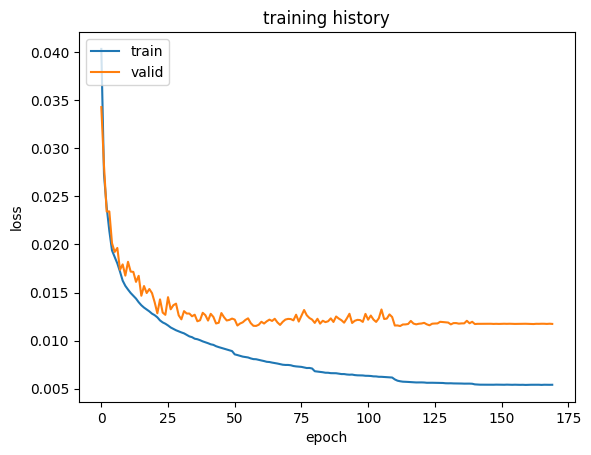

In [ ]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

### **Reconstructions using above**

In [ ]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

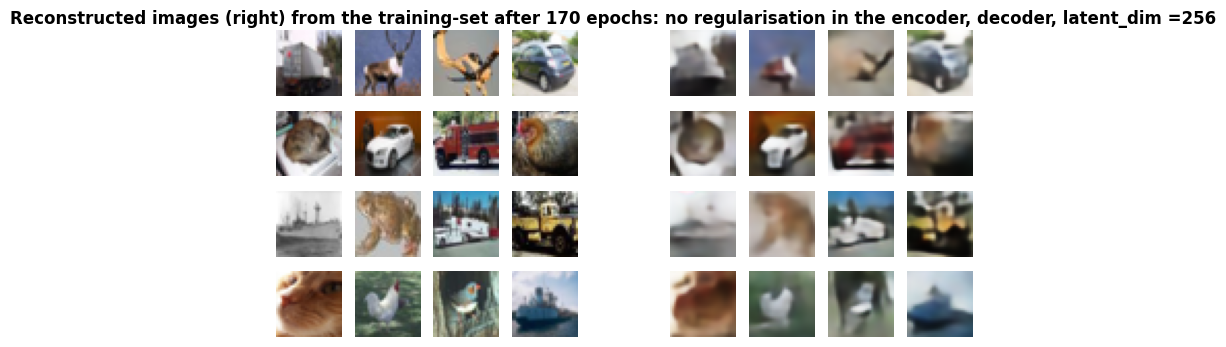

In [ ]:
plot_reconstruction(img_train, 'training', 123, 170)

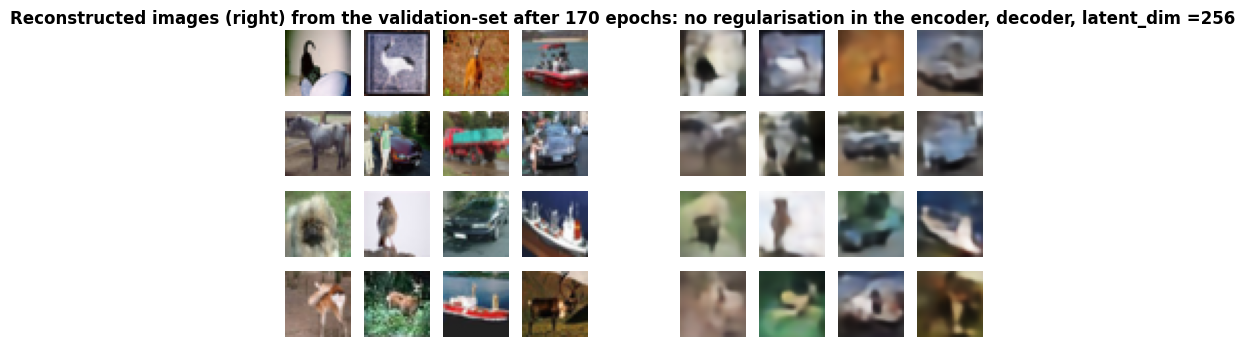

In [ ]:
plot_reconstruction(img_valid, 'validation', 123, 170)

The validation set performance is quite far from the training set performance.

# **Training 2**

In [ ]:
initializer = initializers.HeNormal(seed=123)

K.clear_session()

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=1173, decay_rate=0.92)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75, callbacks=[callback])

Epoch 1/75
391/391 [==============================] - 92s 147ms/step - loss: 0.0399 - accuracy: 0.4855 - val_loss: 0.0337 - val_accuracy: 0.4401
Epoch 2/75
391/391 [==============================] - 51s 130ms/step - loss: 0.0266 - accuracy: 0.4952 - val_loss: 0.0277 - val_accuracy: 0.5106
Epoch 3/75
391/391 [==============================] - 51s 130ms/step - loss: 0.0242 - accuracy: 0.5374 - val_loss: 0.0238 - val_accuracy: 0.5454
Epoch 4/75
391/391 [==============================] - 51s 130ms/step - loss: 0.0214 - accuracy: 0.5763 - val_loss: 0.0212 - val_accuracy: 0.5806
Epoch 5/75
391/391 [==============================] - 51s 131ms/step - loss: 0.0193 - accuracy: 0.5890 - val_loss: 0.0199 - val_accuracy: 0.6007
Epoch 6/75
391/391 [==============================] - 51s 130ms/step - loss: 0.0186 - accuracy: 0.5952 - val_loss: 0.0193 - val_accuracy: 0.5988
Epoch 7/75
391/391 [==============================] - 51s 130ms/step - loss: 0.0180 - accuracy: 0.5998 - val_loss: 0.0183 - val_ac

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps=782, decay_rate=0.92)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, callbacks=[callback])

Epoch 1/50
391/391 [==============================] - 78s 135ms/step - loss: 0.0082 - accuracy: 0.7133 - val_loss: 0.0109 - val_accuracy: 0.6997
Epoch 2/50
391/391 [==============================] - 51s 130ms/step - loss: 0.0082 - accuracy: 0.7135 - val_loss: 0.0109 - val_accuracy: 0.7028
Epoch 3/50
391/391 [==============================] - 51s 130ms/step - loss: 0.0081 - accuracy: 0.7141 - val_loss: 0.0110 - val_accuracy: 0.7007
Epoch 4/50
391/391 [==============================] - 51s 130ms/step - loss: 0.0081 - accuracy: 0.7141 - val_loss: 0.0108 - val_accuracy: 0.6996
Epoch 5/50
391/391 [==============================] - 51s 130ms/step - loss: 0.0081 - accuracy: 0.7142 - val_loss: 0.0110 - val_accuracy: 0.6999
Epoch 6/50
391/391 [==============================] - 51s 130ms/step - loss: 0.0081 - accuracy: 0.7143 - val_loss: 0.0109 - val_accuracy: 0.7012
Epoch 7/50
391/391 [==============================] - 51s 130ms/step - loss: 0.0081 - accuracy: 0.7144 - val_loss: 0.0111 - val_ac

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.000001, decay_steps=391, decay_rate=0.92)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, callbacks=[callback])

Epoch 1/20
391/391 [==============================] - 77s 134ms/step - loss: 0.0077 - accuracy: 0.7173 - val_loss: 0.0109 - val_accuracy: 0.7056
Epoch 2/20
391/391 [==============================] - 51s 130ms/step - loss: 0.0077 - accuracy: 0.7177 - val_loss: 0.0109 - val_accuracy: 0.7023
Epoch 3/20
391/391 [==============================] - 51s 130ms/step - loss: 0.0077 - accuracy: 0.7174 - val_loss: 0.0109 - val_accuracy: 0.7048
Epoch 4/20
391/391 [==============================] - 51s 130ms/step - loss: 0.0076 - accuracy: 0.7175 - val_loss: 0.0109 - val_accuracy: 0.7037
Epoch 5/20
391/391 [==============================] - 51s 130ms/step - loss: 0.0076 - accuracy: 0.7178 - val_loss: 0.0109 - val_accuracy: 0.7050
Epoch 6/20
391/391 [==============================] - 51s 130ms/step - loss: 0.0076 - accuracy: 0.7177 - val_loss: 0.0109 - val_accuracy: 0.7034
Epoch 7/20
391/391 [==============================] - 51s 130ms/step - loss: 0.0076 - accuracy: 0.7179 - val_loss: 0.0109 - val_ac

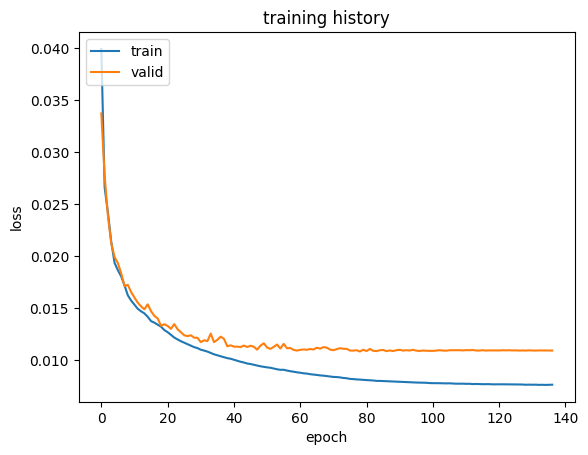

In [ ]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

### **Reconstructions**

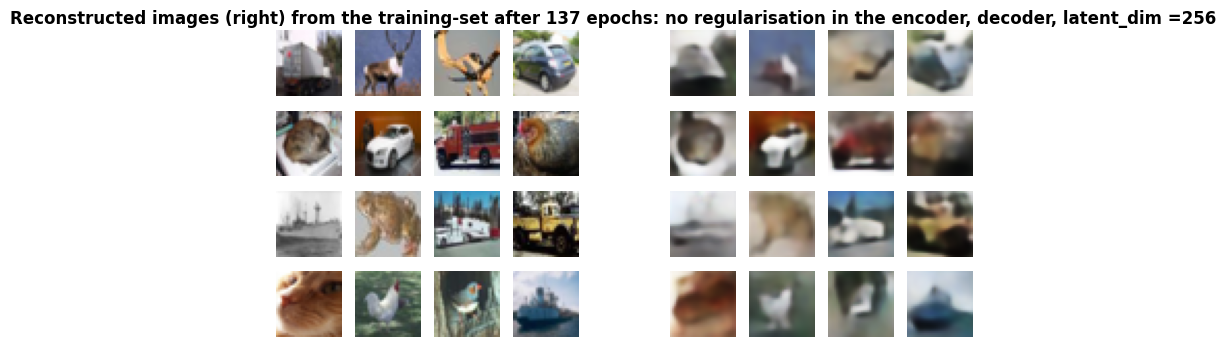

In [ ]:
plot_reconstruction(img_train, 'training', 123, 137)

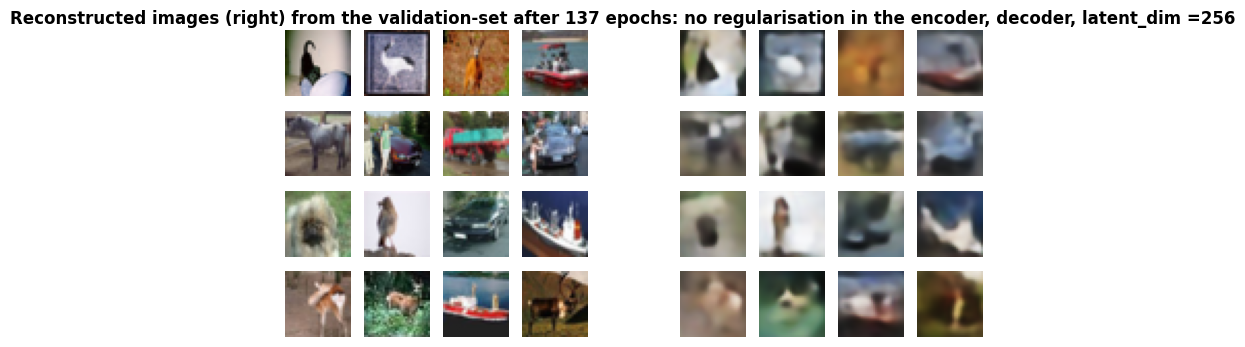

In [ ]:
plot_reconstruction(img_valid, 'validation', 123, 137)

The first training mode gave results with higher accuracy, although the training was better controlled with the learning decay in the second mode.